<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <font style="color:#00797C;padding-bottom:-100px"><center><b><font size="+3">Calculation and Modeling of Variogram Anisotropy</font></b></center></p>
    <font style="color:#00797C;padding-bottom:50px"><center><b><font size="+2">A Companion Notebook to Geostatistics Lessons</font></b></center></p>    
</div>

<p class="author" style="padding: 0;"><center><b>Haoze Zhang, Luis Davila, and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>September 10, 2025</b></center></p>

---


# Outline

The following notebook provides a demonstration of the theory presented in [Calculation and Modeling of Variogram Anisotropy](https://geostatisticslessons.com/lessons/variogramanisotropy). Obtaining the correct anisotropy of the variograms is important in geological modeling. This notebook demonstrates multiple methods of inferring variogram anisotropy. Methods are applied to both dense and sparse data, which allow for clearer illustration of different concepts. The progression and aim of this notebook is further detailed:

1. **Create Dense and Sparse Datasets**
    - Simulate a gridded realization with a "true" underlying variogram
    - The gridded realization is treated as the dense dataset (40,000 points)
    - The gridded realization is randomly sampled to generate the sparse dataset (200 points)

3. **Circle Variogram with Dense Data**
    - Calculate experimental variograms in 16 evenly discretized directions in the (x,y) plane, applying narrow and wide azimuth tolerances
    - Fit a variogram model to all 16 directions simultaneously, autofitting the angles and ranges of the principal directions; his is repeated for each of the two azimuth tolerance cases
    - Compare the variogram models against the true variogram. It is shown that dense data permits reliable inference of the principal directions of anisotropy, but the variogram model associated with the wider azimuth tolerance (not strictly required here, but will be with sparse data) case understates the true anisotropy

2. **Circle Variogram with Sparse Data**
    - Repeat the approach described above with the dense data, though only using a necessarily wide azimuth tolerance for the experimental variogram
    - It is demonstrated that the inferred principal directions and anisotropy are reasonable, though predictably less precise than with the dense data

3. **Variogram Volume with Dense Data**
    - Calculate a variogram volume (or map) directly on the dense data, which permits stable population of all volume bins
    - Fit a variogram model to the variogram volume, thereby extracting the principal directions and ranges
    - Compare the fit variogram model against the true variogram model, showing very precise reproduction

3. **Variogram Volume with Sparse Data (Neutral Model)**
    - Demonstrate that the direct calculation of a variogram volume on sparse data is not stable
    - Generate a neutral model to smooth short scale variability and reveal underlying structure
    - Calculate a variogram volume on the gridded neutral model, thereby populating all bins in a stable fashion with the smoothed continuity
    - Fit a variogram model to the variogram volume of the neutral model, identifying the principal directions, though not ranges, as the neutral model is too smooth
    - Calculate experimental variograms on the data along the identified principal directions, before fitting with with a variogram model
    - Compare the inferred anisotropy from the circle search and variogram volume (with neutral model) approaches, where the latter is shown to provide better reproduction of the true variogram in this case

3. **Moment of Inertia (MOI)**
    - Demonstrate moment of inertia as a final method for determining principal directions of continuity
    - Extract the principal directions from the neutral model variogram volume using the MOI tensor matrix
    - Calculate experimental variograms along the principal directions and fit a variogram model, before comparing to earlier results 

The presented workflow may be extended to represent other deposits. Inline annotations with each step will note practical adjustments that may be necessary for this extension.

---

Import required packages:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rmsp

Activate rmsp and set some plotting parameters:

In [2]:
rmsp.activate()

var = rmsp.Variable("var").set_variable_params(clim=(-2.5, 2.5),
                                               axis_lim=(-3.0, 3.0),
                                               cmap='pink')
var.clone('estimate')  # copy coloring

License cleq45ynq00hwgomxq8ns35e7 checked out by clp1l0q1n2347lb22mk5w1a0u to cm5yh1itt25gxal02g56h30hs expires in 18 minutes. RMSP is up to date!


Variable('var', col='estimate')

--- 
# Create Dense and Sparse Datasets


## Generate dense grid of values

Create a 2D simulation `grid`. Concepts in this notebook extend to 3D, though 2D is used for more concise illustration.

In [3]:
grid = rmsp.GridData(griddef=rmsp.GridDef(xcmin=5.0,
                                          ycmin=5.0,
                                          zcmin=0.5,
                                          azimuth_deg=0.0,
                                          nu=200,
                                          nv=200,
                                          nz=1,
                                          usize=10.0,
                                          vsize=10.0,
                                          zsize=1.0,
                                          blockindices='full'))
grid.griddef.to_table()

,Easting,Northing
minimum (m),0.0,0.0
maximum (m),2000.0,2000.0
size (m),10.0,10.0
number,200,200


Initialize a "true" anisotropic variogram model that will be simulated over the `grid`. The major direction of continuity of the true variogram is 45° with a 4:1 anisotropy ratio.

In [4]:
variomod_true = rmsp.VarioModel.from_params(num_struct=1,
                                            nugget=0.0,
                                            shapes='spherical',
                                            var_contribs=1.0,
                                            angles=[45, 0, 0],
                                            ranges=[400, 100, 1])
variomod_true.to_table()

,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,45.0
Angle 2,,0.0
Angle 3,,0.0
Range 1,,400.0
Range 2,,100.0
Range 3,,1.0


Unconditionally simulate a single realization:

In [5]:
random_seed = 42
grid[var] = rmsp.SGSimulator().simulate(locations=grid,
                                        search=rmsp.Search.from_vario_buffer(
                                            variomod_true, max_comps=40),
                                        vario=variomod_true,
                                        reals=1,
                                        seed=random_seed,
                                        copy_meta=False)
grid.head()

,var
0,-0.465418
1,-0.341207
2,-0.462143
3,-0.512963
4,-0.539882


Convert the grid to point values to facilitate variogram calculations. Variograms may be calculated directly on a grid (and more rapidly), but calculation on dense point values will allow for clear use of typical experimental lag/azimuth tolerances.

In [6]:
griddata = grid.to_pointdata()

## Sample the grid for a sparse dataset

Randomly select 200 values from the dense grid to form the sparse dataset:

In [7]:
data = grid.sample(200, random_state=random_seed).to_pointdata()
data.head()

,x,y,z,var
32823,235.0,1645.0,0.5,-0.582362
16298,985.0,815.0,0.5,1.599065
28505,1055.0,1425.0,0.5,-0.292528
6689,895.0,335.0,0.5,0.561600
26893,935.0,1345.0,0.5,-0.574271


Plot the full grid (representing the dense data) and the sampled sparse data. Also overlay the underlying "true" variogram model as an iso-contour of the 0.95 standardized variogram value (displayed ellipse). This approach will be used for comparing anisotropy of various methods that follow.

Note that the `plan_view` code and ellipse plotting parameters `ellipse_pars` are placed in a function/dictionary to permit compact re-use in susequent sections.

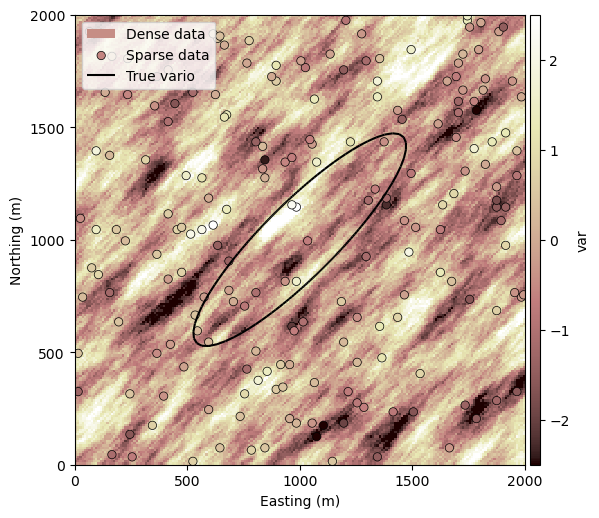

In [8]:
vario_value = 0.95
ellipse_pars = dict(lw=1.5, origin=grid.spatial_centroid, scale=2.0)


def plan_view(dense=True, sparse=True, title=''):
    fig, ax = plt.subplots(figsize=(6, 6))
    xlim = grid.griddef.xyz_extents['x']
    ylim = grid.griddef.xyz_extents['y']
    if dense:
        grid.sectionplot(var,
                         label='Dense data',
                         ax=ax,
                         title=title,
                         xlim=xlim,
                         ylim=ylim)
    if sparse:
        data.sectionplot(var,
                         edgecolors='k',
                         label='Sparse data',
                         ax=ax,
                         title=title,
                         xlim=xlim,
                         ylim=ylim)
    variomod_true.sectionplot_draw(ax,
                                   vario_value=vario_value,
                                   **ellipse_pars,
                                   c='k',
                                   label='True vario')
    return ax


ax = plan_view()
_ = ax.legend(loc=2)

---
# Circle Variogram with Dense Data

Experimental variograms will be calculated from the dense (gridded) data using 10° and 30° azimuth tolerances. The primary goal of this section, is to illustrate how increasing tolerances in the experimental variogram calculations (even where not necessary with dense data) serve to understate true anisotropy.

An experimental variogram circle approach is used, where the variogram is calculated along 16 directions that discretize a 2D plane, before fitting a single variogram model that best fits all directions.  When dealing with 3D data a spherical search can be used rather than a circle search (as seen in the Lesson); the core idea here is similar.

Begin by defining variogram lags, which align with the dense gridded spacing:

In [9]:
lags = rmsp.Lags(10, 5, 40)

Now calculate the variogram circle using the 10° and 30° azimuth tolerances:

In [10]:
expvario_circles = {
    azmtol:
    rmsp.ExpVario().calculate(
        griddata,
        var,
        rmsp.ExpVarioSearch.circle(lags, azmtol=azmtol, ndir=16),
    )
    for azmtol in [10, 30]
}

Plot the results, where it can be seen that anisotropy reduces using an increased tolerance (e.g., the ranges are similar in most directions but at 45° and 225° azimuth plot the ranges are shorter, which indicates a less anisotropy using larger tolerances):

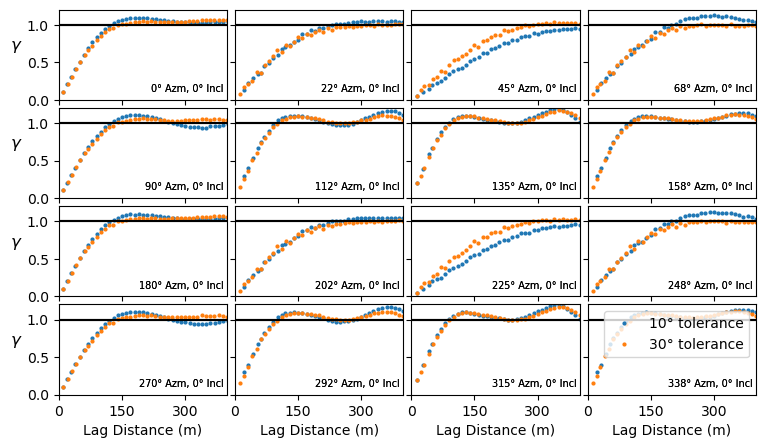

In [11]:
fig, axes = expvario_circles[10].gridplot(figsize=(9, 5),
                                          label='10° tolerance')
_ = expvario_circles[30].gridplot(axes=axes, c='C1', label='30° tolerance')
_ = axes[-1].legend(loc=1)

Fit the variogram model to the 16 directions. In this process, the auto fitting algorithm will determine the major orientation of anisotropy (`angle1`) while the other angles are fixed (no inclination or tilt in with two dimensional data). Some constraints are applied here, yielding a semi-automatic variogram fit: 
- Minor direction has 1m of range (not required but emphasizing 2D data)
- `angle2` and `angle3` are  0 (only azimuth is needed in 2D)
- `order_ranges=True` to enforce `range1`>`range2`>`range3`
  
The fitting parameters are set in a dictionary for re-use. The auto fitted model may not appear correctly fit to any one particular direction, however the fitting error is minimized across all directions collectively.

In [12]:
fitpars = dict(num_struct=1,
               shapes="spherical",
               nugget=0.0,
               range3=1.0,
               angle2=0.0,
               angle3=0.0,
               order_ranges=True)

variomod_circles = {}
for azmtol in expvario_circles:
    variomod_circles[azmtol] = rmsp.VarioModel.fit_experimental(
        expvario_circles[azmtol], **fitpars)
    print(f'Azimuth tolerance = {azmtol}°')
    display(variomod_circles[azmtol].to_table())

Azimuth tolerance = 10°


,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,45.9
Angle 2,,0.0
Angle 3,,0.0
Range 1,,408.7
Range 2,,96.0
Range 3,,1.0


Azimuth tolerance = 30°


,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,46.3
Angle 2,,0.0
Angle 3,,0.0
Range 1,,311.5
Range 2,,108.1
Range 3,,1.0


Observe in the tables above, that the fit `angle1` is very near to the known underlying true major azimuth of 45°. The Range 1 - Range 2 anisotropy is shown to significantly decrease with increasing azimuth tolerance in the experimental direction.

Plot all experimental variograms (in all directions) and the  fitted model, to ensure appropriate fitting:

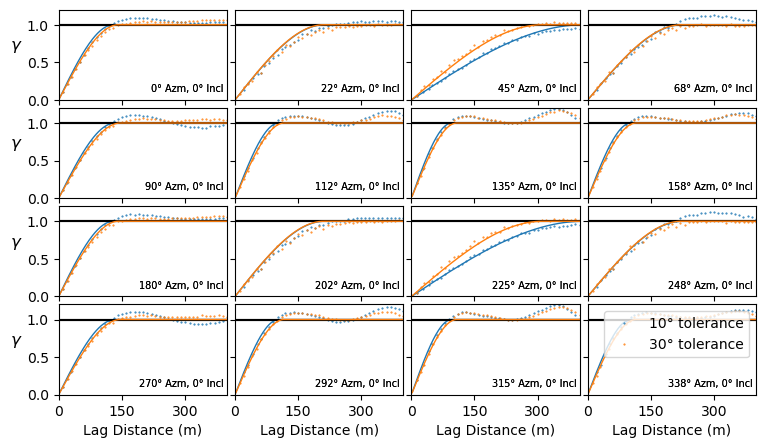

In [13]:
fig, axes = expvario_circles[10].gridplot(figsize=(9, 5),
                                          ms=0.5,
                                          model=variomod_circles[10],
                                          model_kws={'c': 'C0'},
                                          label='10° tolerance')
_ = expvario_circles[30].gridplot(axes=axes,
                                  c='C1',
                                  ms=0.5,
                                  model=variomod_circles[30],
                                  label='30° tolerance')
_ = axes[-1].legend(loc=1)

Continuing to utilize the variogram iso-contour ellipse approach, visualize the orientation and anisotropy of the fit variogram models against the true underlying model. The inferred orientation is confirmed to be precise, when based on experimental variograms that are reliably informed by the gridded data. The model that is based 10° azimuth tolerance is shown to reproduce the true anisotropy, whereas the 30° tolerance is shown to understate the true anisotropy.

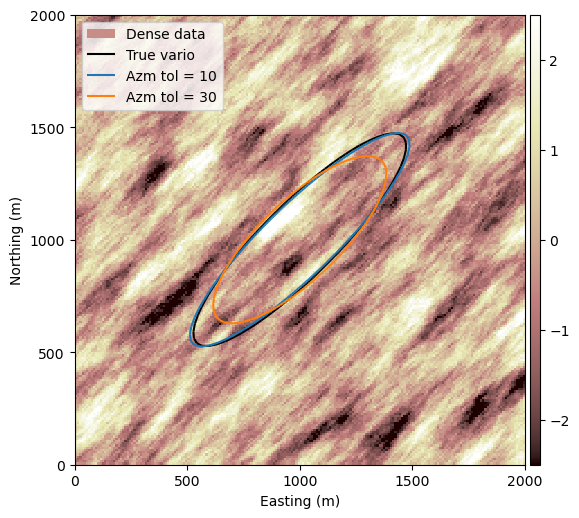

In [14]:
ax = plan_view(sparse=False)
for azmtol, c in zip(variomod_circles, ['C0', 'C1']):
    variomod_circles[azmtol].sectionplot_draw(ax,
                                              vario_value=vario_value,
                                              **ellipse_pars,
                                              c=c,
                                              label=f'Azm tol = {azmtol}')

_ = ax.legend(loc=2)

---
# Circle Variogram with Sparse Data

Apply the same approach as the preceding section, but utilizing the sparse sampled data.

Begin by defining variogram lags that are necessarily wider based on the sparse sample spacing:

In [15]:
lags = rmsp.Lags(50, 35, 10)
lags

Experimental variogram lag definition:
      Distance (m) Tolerance (m) Min. Distance (m) Max. Distance (m)
Lag 0         50.0          35.0              15.0              85.0
Lag 1        100.0          35.0              65.0             135.0
Lag 2        150.0          35.0             115.0             185.0
Lag 3        200.0          35.0             165.0             235.0
Lag 4        250.0          35.0             215.0             285.0
Lag 5        300.0          35.0             265.0             335.0
Lag 6        350.0          35.0             315.0             385.0
Lag 7        400.0          35.0             365.0             435.0
Lag 8        450.0          35.0             415.0             485.0
Lag 9        500.0          35.0             465.0             535.0

Now calculate the variogram circle using 30° tolerances, which was found to be necessary for stable results with the sparse data.

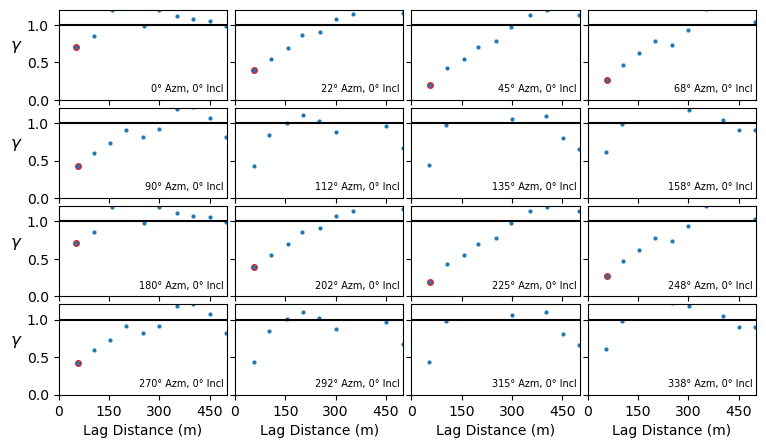

In [16]:
search_circle = rmsp.ExpVarioSearch.circle(lags, azmtol=30, ndir=16)
expvario_circle = rmsp.ExpVario().calculate(data, var, search_circle)
_ = expvario_circle.gridplot(figsize=(9, 5))

Fit the variogram model to the 16 directions, applying the same fitting constraints that were detailed in the last section:

In [17]:
variomod_circle = rmsp.VarioModel.fit_experimental(expvario_circle, **fitpars)
variomod_circle.to_table()

,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,55.9
Angle 2,,0.0
Angle 3,,0.0
Range 1,,497.0
Range 2,,130.3
Range 3,,1.0


Observe in the table above, that the fit `angle1` is ~11° from the known underlying true major azimuth of 45°, if not closely matching due to the 200 sample data that the experimental variogram is based on.

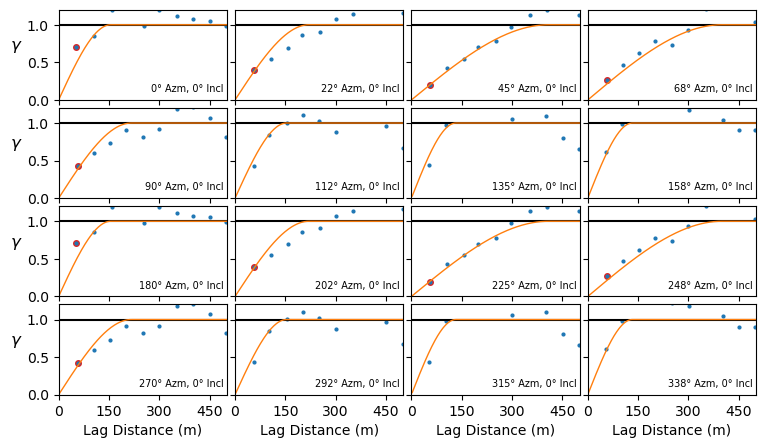

In [18]:
_ = expvario_circle.gridplot(model=variomod_circle, figsize=(9, 5))

Visualize the orientation and anisotropy of the fit variogram model against the true underlying model. The inferred orientation and anisotropy is shown to be reasonable if not precise, which results from relatively sparse sample data and experimental tolerances.

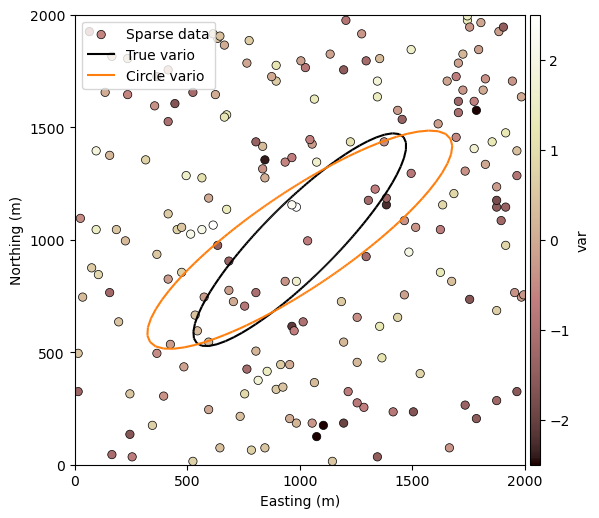

In [19]:
ax = plan_view(dense=False)
variomod_circle.sectionplot_draw(ax,
                                 vario_value=vario_value,
                                 **ellipse_pars,
                                 c='C1',
                                 label='Circle vario')
_ = ax.legend(loc=2)

---
# Variogram Volume with Dense Data

Calculate the variogram volume using the dense gridded values. Unlike with sparse data in the next section, there is no need for a neutral model here, as the dense data reliably supports all variogram volume bins.

In [20]:
expvario_grid = rmsp.ExpVario().calculate_volume(
    griddata,
    var,
    rmsp.ExpVarioVolume([50, 50, 1],
                        [10, 10, 1]),  # Ten lags of 50m in x and y
)

Fit a variogram model to the variogram volume, using the same fitting parameters that were applied with the directional variograms (e.g. Angle 1 unconstrainted, but Angles 2 and 3 constrained):

In [21]:
variomod_grid = rmsp.VarioModel.fit_experimental(expvario_grid, **fitpars)
variomod_grid.to_table()

,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,44.6
Angle 2,,0.0
Angle 3,,0.0
Range 1,,397.0
Range 2,,105.0
Range 3,,1.0


The model fit above is very close to the true known parameters. Plot the variogram volume and the model anisotropy ellipse, ensuring a reasonable fit:

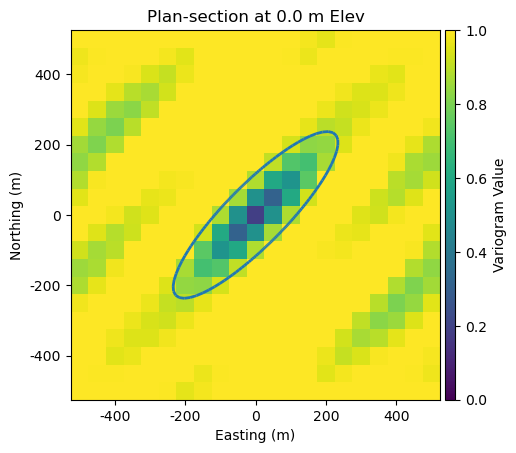

In [22]:
ax = expvario_grid.sectionplot()[1]
_ = variomod_grid.sectionplot_draw(ax, vario_value=vario_value, c='C0', lw=2)

Plot the variogram volume model ellipse against that of the true variogram and underlying dense data. Observe the extremely close reproduction, as is expected when based on dense data:

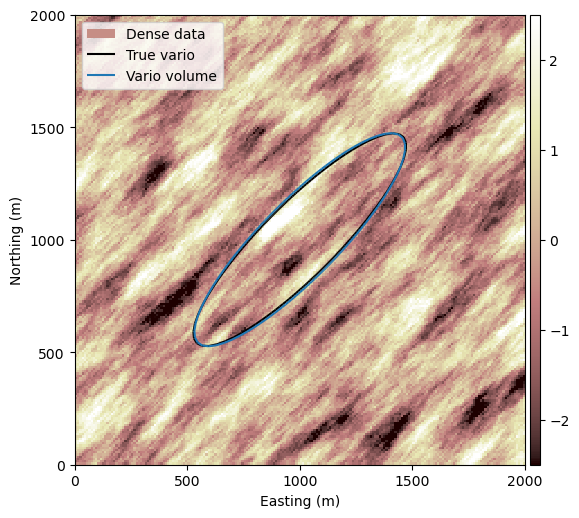

In [23]:
ax = plan_view(sparse=False)
variomod_grid.sectionplot_draw(ax,
                               vario_value=vario_value,
                               **ellipse_pars,
                               c='C0',
                               label='Vario volume')
_ = ax.legend(loc=2)

---
# Variogram Volume with Sparse Data (Neutral Model)


## Issue with direct variogram volume calculation
Unlike the preceding section with dense data, direct calculation of a variogram volume with sparse data yields unstable results, as there is not sufficient data informing each 2D bin. This is shown below:

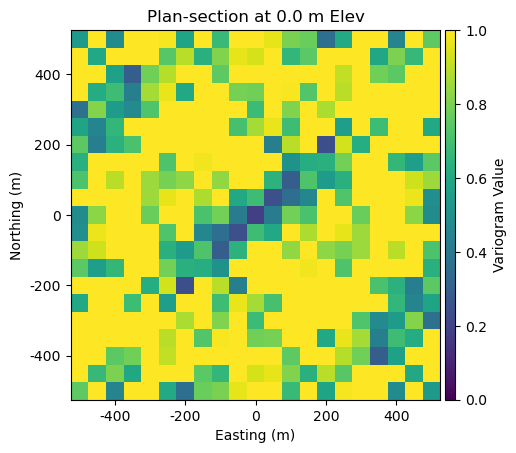

In [24]:
expvario_sparse = rmsp.ExpVario().calculate_volume(
    data,
    var,
    rmsp.ExpVarioVolume([50, 50, 1],
                        [10, 10, 1]),  # Ten lags of 50m in x and y
)
_ = expvario_sparse.sectionplot()

## Neutral model

To obtain the principal angles from a variogram volume with sparse data, a neutral model is first created using a high nugget effect and large isotropic range. When input to kriging, this will filter high-frequency noise and reveal longer range, artifact free, features of the data. 

In [25]:
vario_smooth = rmsp.VarioModel.from_params(num_struct=1,
                                           nugget=0.3,
                                           shapes='spherical',
                                           var_contribs=0.7,
                                           angles=[0, 0, 0],
                                           ranges=[500, 500, 1])
vario_smooth

             Nugget Structure 1
Contribution  0.300       0.700
Model Shape           spherical
Angle 1                     0.0
Angle 2                     0.0
Angle 3                     0.0
Range 1                   500.0
Range 2                   500.0
Range 3                     1.0


Dual kriging (no search parameters required) is used for speed, and recommended in cases with less than 5000 data. A restricted but large search (100+ data) is recommended with greater than 5000 data.

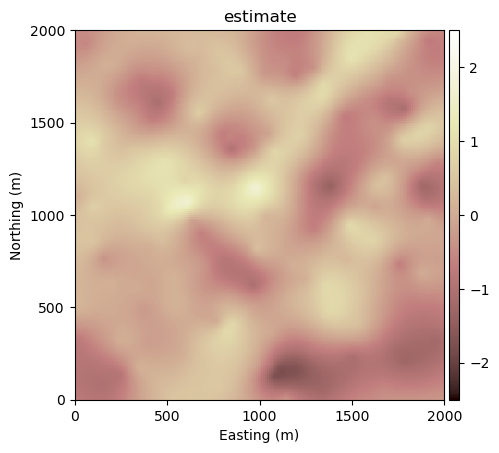

In [26]:
krige = rmsp.KrigeEstimator("dual", vario_smooth, num_discret=[3, 3, 1])
grid["estimate"] = krige.estimate(grid, data, var.col)
_ = grid.sectionplot('estimate')

## Variogram volume

Calculate the variogram volume using the gridded values from the neutral model:

In [27]:
expvario_neutral = rmsp.ExpVario().calculate_volume(
    grid.to_pointdata(),
    "estimate",
    rmsp.ExpVarioVolume([50, 50, 1],
                        [10, 10, 0]),  # Ten lags of 50m in x and y
)

Fit a variogram model to the neutral variogram volume using the same parameters as the previous section:

In [28]:
variomod_neutral = rmsp.VarioModel.fit_experimental(expvario_neutral,
                                                    **fitpars)
variomod_neutral.to_table()

,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,225.5
Angle 2,,0.0
Angle 3,,0.0
Range 1,,647.5
Range 2,,383.7
Range 3,,1.0


Observe in the table above, that the inferred Angle 1 is within 0.5° of the true angle1 (given symmetry of the variogram, angle1 above is equivalent to 45.5°).

Plot the variogram volume and the anisotropy ellipse to check the model fit against the variogram volume of the neutral model:

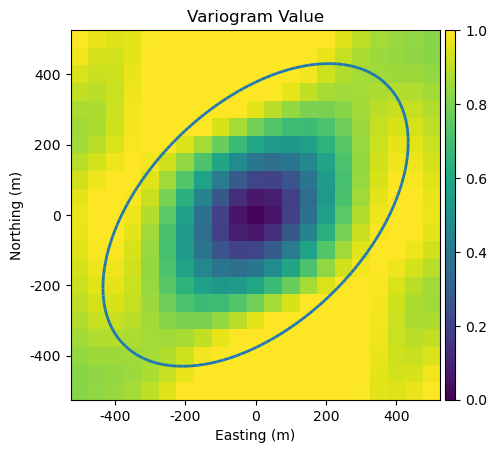

In [29]:
ax = expvario_neutral.sectionplot()[1]
_ = variomod_neutral.sectionplot_draw(ax,
                                      vario_value=vario_value,
                                      c='C0',
                                      lw=2)

Compare the anisotropy ellipse of the neutral model and true variogram model. The neutral model yields trusted principal angles, but its smoothed nature leads to less apparent anisotropy and generally longer ranges. This highlights that the variogram of the neutral model may be utilized for extracting principal directions, before calculating/fitting experimental variograms of the data along those directions (see next section), but should not otherwise be utilized directly in estimation or simulation.

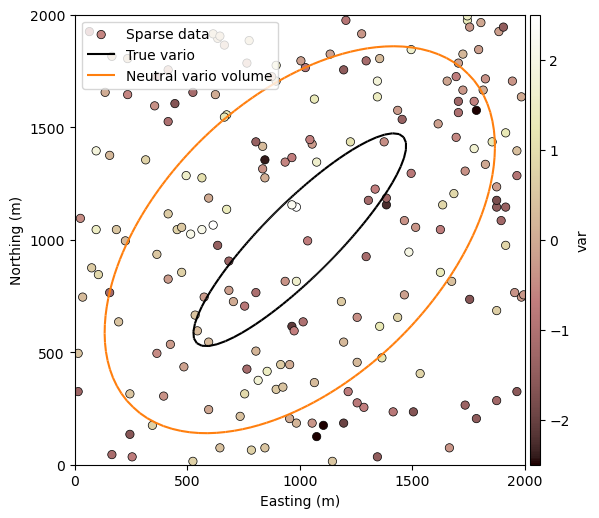

In [30]:
ax = plan_view(dense=False)
variomod_neutral.sectionplot_draw(ax,
                                  vario_value=vario_value,
                                  **ellipse_pars,
                                  c='C1',
                                  label='Neutral vario volume')
_ = ax.legend(loc=2)

## Directional variogram along principal directions

Inspect the inferred principal directions from the variogram model that was fit to the neutral model. These directions would be used for subsequent directional experimental variogram calculation with the data.

In [31]:
principals = variomod_neutral.get_principals()
principals

[{'azm': 225.51338725176404, 'incl': 0.0},
 {'azm': 315.513387251764, 'incl': 0.0},
 {'azm': 0.0, 'incl': 90.0}]

Calculate experimental variograms along the principal directions (other than the 3rd one as 2D). Note that slightly wider lag tolerances are used here, relative to the circle search, based on observed stability along these particular angles.

In [32]:
lags = rmsp.Lags(50, 35, 10)
searches = [
    rmsp.ExpVarioSearch(p['azm'], 0, lags, azmtol=30) for p in principals[:2]
]
expvario_princ = rmsp.ExpVario().calculate(data, var, searches)

Fit the variogram model, fixing angle1 to follow the inferred first principal direction:

In [33]:
variomod_princ = rmsp.VarioModel.fit_experimental(expvario_princ,
                                                  **fitpars,
                                                  angle1=principals[0]['azm'])
variomod_princ.to_table()

,Nugget,Structure 1
Contribution,0.000,1.000
Model Shape,,spherical
Angle 1,,225.5
Angle 2,,0.0
Angle 3,,0.0
Range 1,,388.7
Range 2,,146.0
Range 3,,1.0


Check the model fit:

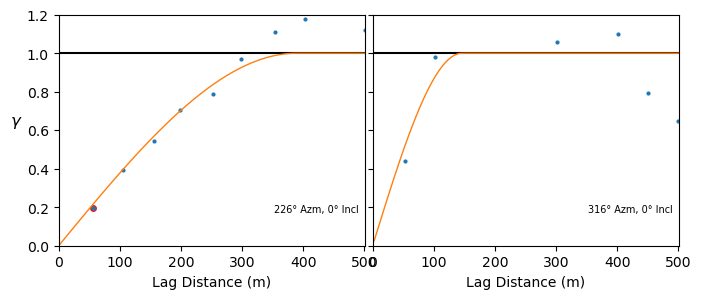

In [34]:
_ = expvario_princ.gridplot(figsize=(8, 3), model=variomod_princ)

Inspect the modeled variogram (orange) against the true variogram (black). The anisotropy remains understated, as may be expected with the large azimuth/lag tolerance parameters that were necessary with the sparse data. Nevertheless, the principal angles derived from the neutral model are shown to be accurate, and the overall fit is a reasonable match for the true underlying continuity. The variogram model derived from the circle search is overlain (blue) to highlight its less accurate principal angles, although it may perform well in other scenarios (particularly with denser data, as shown).

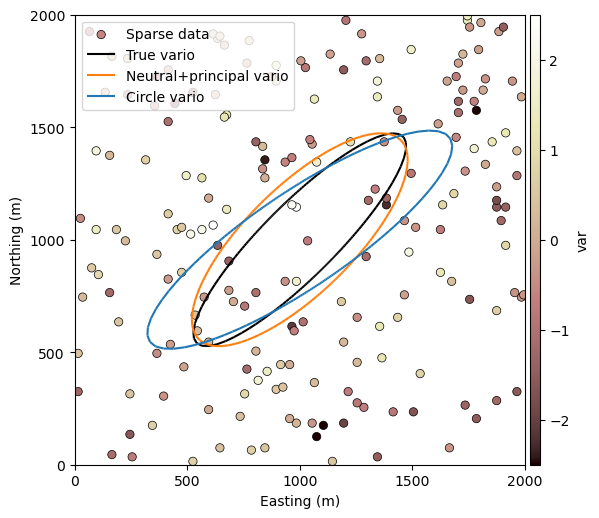

In [35]:
ax = plan_view(dense=False)
variomod_princ.sectionplot_draw(ax,
                                vario_value=vario_value,
                                **ellipse_pars,
                                c='C1',
                                label='Neutral+principal vario')
variomod_circle.sectionplot_draw(ax,
                                 vario_value=vario_value,
                                 **ellipse_pars,
                                 c='C0',
                                 label='Circle vario')
_ = ax.legend(loc=2)

---
# Moment of Inertia (MOI) Tensor

The moment of inertia (MOI) tensor is the sum of the mass distribution occurring in a rigid body rotating about the axes of rotation. The principal direction of the MOI is the direction in which the rigid body is concentrated. The major direction is related to the smallest moment of inertia.

This section present the MOI tensor as a final methodology for determining the principal directions of continuity. These directions are used for directional experimental variogram calculation, followed by variogram modeling. 

## Calculate MOI based principal directions

Calculate the MOI tensor matrix following the formulation seen in Chapter 2 of Davila (2024), which permits specifying an inverse distance `power` for increased weighting of nearer lags.


*Davila, L. (2024) Automatic Variogram Modeling, M.Sc. Thesis, University of Alberta:* <https://era.library.ualberta.ca/items/2e44d88c-6bf6-48b7-b619-02284f026210>

In [36]:
expvario_neutral.data["Lag Distance"].describe()

count    441.000000
mean     401.561698
std      149.012940
min       19.497193
25%      300.215235
50%      412.406468
75%      509.946789
max      707.059628
Name: Lag Distance, dtype: float64

In [37]:
angles = rmsp.calc_moi_angles(expvario_neutral, sill=1.0, power=5)
angles

[52.5, -0.0, -0.0]

## Calculate and visualize variogram along principal directions

Create principal directions from MOI inferred direction

In [38]:
azms = [angles[0], angles[0] - 90]

lags = rmsp.Lags(50, 35, 10)
searches = [rmsp.ExpVarioSearch(azm, 0, lags, azmtol=30) for azm in azms]
expvario_moi = rmsp.ExpVario().calculate(data, var, searches)

Fit variogram

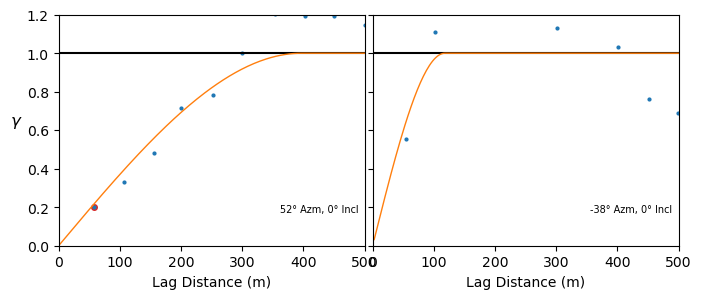

In [39]:
variomod_moi = rmsp.VarioModel.fit_experimental(expvario_moi,
                                                **fitpars, angle1=azms[0])
variomod_moi.to_table()
_ = expvario_moi.gridplot(figsize=(8, 3), model=variomod_moi)

## Visually compare
Compare inferred MOI directions (overlain model) against variogram volume of neutral model that was input to MOI:

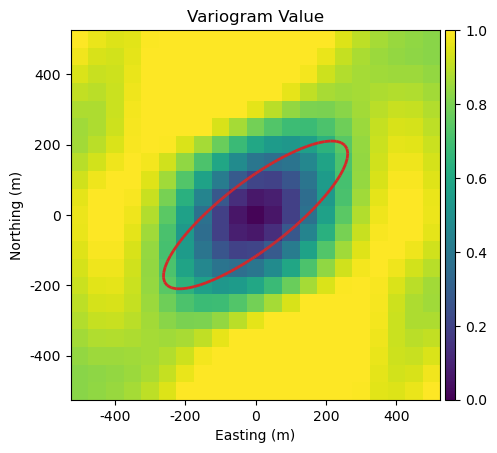

In [40]:
ax = expvario_neutral.sectionplot()[1]
_ = variomod_moi.sectionplot_draw(ax, vario_value=vario_value,
                                      c='C3',
                                      lw=2)

Inspect visually against the circle based variogram and true variogram. The MOI approach is shown to outperform the circle based approach with sparse data. Also note, however, that that the MOI based angles underperform direct fitting of the variogram model to the neutral based variogram volume (prior section), which is case dependent (here MOI angles over influenced by distracting features along the covariance volume edges).

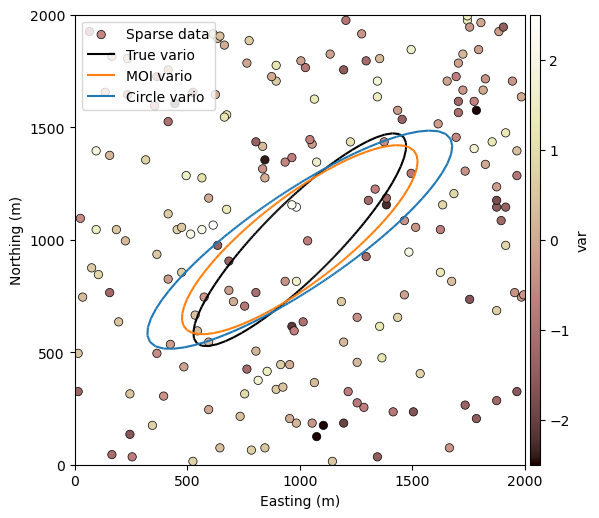

In [41]:
ax = plan_view(dense=False)
variomod_moi.sectionplot_draw(ax,
                              vario_value=vario_value,
                              **ellipse_pars,
                              c='C1',
                              label='MOI vario')
variomod_circle.sectionplot_draw(ax,
                                 vario_value=vario_value,
                                 **ellipse_pars,
                                 c='C0',
                                 label='Circle vario')
_ = ax.legend(loc=2)

--- 
# Closing Comments

Geological formations are almost always anisotropic. The first step in variogram determination is to establish the principal directions. This notebooks demonstrates methodologies for determining principal directions of continuity and models of anisotropy from sparse data. Experimental directional variograms, neutral models, and variogram volumes are useful tools to help with this first step. After finding the principal directions, it is necessary to compute reliable directional variograms. The tolerance and apparent anisotropy must be considered carefully. Dense and sparse data were used to illustrate how large variogram tolerances may be practically necessary, but will understate the true anisotropy.

---

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>